Use any image dataset and perform CNN using Keras/PyTorch

Inspiration: https://www.youtube.com/watch?v=9aYuQmMJvjA&list=PLQVvvaa0QuDdeMyHEYc0gxFpYwHY2Qfdh&index=5

Dataset: https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

Note: Try the VGG Architecture, for better performance.
Link: https://towardsdatascience.com/how-to-use-a-pre-trained-model-vgg-for-image-classification-8dd7c4a4a517

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torchvision

/opt/homebrew/Caskroom/miniconda/base/envs/CPU/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniconda/base/envs/CPU/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <320D718F-E2FD-3687-B2F0-E83CF97743B1> /opt/homebrew/Caskroom/miniconda/base/envs/CPU/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <EF59E044-2498-3CB6-AAE1-EEA304AC32DE> /opt/homebrew/Caskroom/miniconda/base/envs/CPU/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Set to 'True' when running for First time
REBUILD_DATA = False

# Better to have classes, for improved repeatability
class DogsVsCats():
    # Make images the same size - Pad Images, Rotate, & more
    IMG_SIZE = 50
    
    CATS = "kagglecatsanddogs_5340/PetImages/Cat"
    DOGS = "kagglecatsanddogs_5340/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            
            # 'tqdm' is for Progress Bars
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1
                    except Exception as e:
                        pass
                    #print(str(e))
                    
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)
        
if REBUILD_DATA:
    dogsvcats = DogsVsCats()
    dogsvcats.make_training_data()

In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [4]:
print("Number of training examples: ", len(training_data))

Number of training examples:  24946


In [5]:
print(training_data[1])

[array([[120, 118,  47, ...,  64,  65,  65],
        [118, 116,  49, ...,  64,  65,  65],
        [120, 120,  51, ...,  65,  64,  66],
        ...,
        [ 47,  47,  45, ..., 112,   4,  71],
        [ 47,  47,  47, ..., 105,   3,  76],
        [ 40,  48,  47, ...,  88,  23,  78]], dtype=uint8) array([1., 0.])]


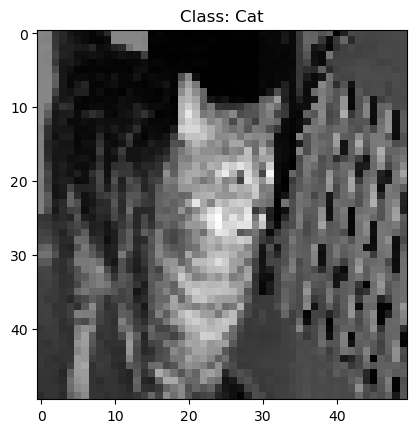

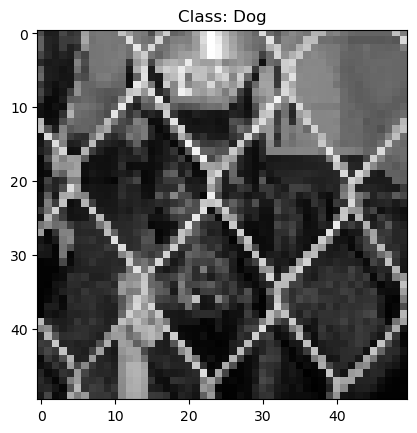

In [6]:
import matplotlib.pyplot as plt

n = 1

plt.imshow(training_data[n][0], cmap="gray")

img_class = "Dog" if training_data[n][1][1] == 1 else "Cat"
plt.title(f"Class: {img_class}")
plt.show()

n = 100

plt.imshow(training_data[n][0], cmap="gray")

img_class = "Dog" if training_data[n][1][1] == 1 else "Cat"
plt.title(f"Class: {img_class}")
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)
print()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)



In [9]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [10]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

/var/folders/67/4mxjfv5j26z772wt9gjhy6gw0000gn/T/ipykernel_51392/3353633519.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_11601pzv9m/croot/pytorch_1681837278807/work/torch/csrc/utils/tensor_new.cpp:233.)
  X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)


In [11]:
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)

print("Validation set size:", val_size)
print()

Validation set size: 2494



In [12]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print("Number of Training Examples:", len(train_X))
print("Number of Testing Examples:", len(test_X))
print()

Number of Training Examples: 22452
Number of Testing Examples: 2494



In [15]:
BATCH_SIZE = 100
EPOCHS = 1

losses = []
accuracies = []

for epoch in range(EPOCHS):
    # To calculate Average Loss
    epoch_loss = 0
    
    # To calculate Accuracy
    total = 0
    correct = 0
    
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # From 0, to the len of x, stepping BATCH_SIZE at a time. It's [:50] for now
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update
        
        # Calculate Training Accuracy
        real_class = torch.argmax(train_y[i])
        net_out = net(train_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
        
        epoch_loss += loss.item()
    
    # Now, epoch_loss is divided by the number of batches processed per epoch, 
    # which is equal to len(train_X) / BATCH_SIZE, to get the average loss per epoch.
    avg_loss = epoch_loss / (len(train_X) / BATCH_SIZE)
    losses.append(avg_loss)
    
    accuracy = round(correct/total, 3)
    accuracies.append(accuracy)

    print(f"Epoch: {epoch} | Loss: {epoch_loss} | Accuracy: {accuracy}")

100%|█████████████████████████████████████████| 225/225 [04:16<00:00,  1.14s/it]

Epoch: 0 | Loss: 53.72064067423344 | Accuracy: 0.578


In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss and accuracy
plt.plot(range(EPOCHS), losses, label='Loss')
plt.plot(range(EPOCHS), accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.title("Loss & Accuracy per Epoch")
plt.legend()
plt.show()

In [ ]:
# Testing Accuracy

correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
        
print("Accuracy: ", round(correct/total, 3))